# Import packages and defining helper function

In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def experiment(config, x):
    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 2)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("estimation")
    axs[1].imshow(plotable(x_hat))
    plt.show()

In [312]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)
gen = iter(dm)

# Defining Experimental Params

In [313]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


# The experiment 

In [314]:
x, y = next(gen)

In [315]:
config["operator_params"]["operator"] = "CompressedSensing"
config["operator_params"]["num_measurements"] = 200
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 1
config["estimator_params"]["step_size_map_initaliser"] = 0.1
config['estimator_params']['lambda'] = 500
config['estimator_params']['potential'] = "mse"

## Operator: Compressed Sensing

In [316]:
config["base_model_params"]["base_model"] = "vae"

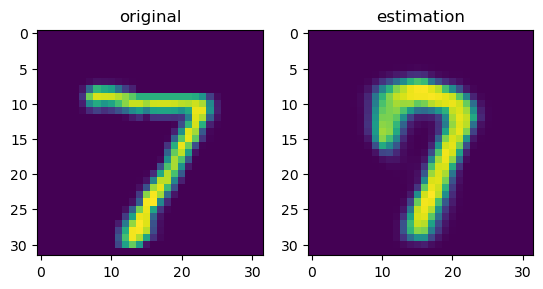

In [347]:
experiment(config, x)

In [233]:
config["base_model_params"]["base_model"] = "gan"
config['estimator_params']['potential'] = "mse"
config['estimator_params']['lambda'] = 10

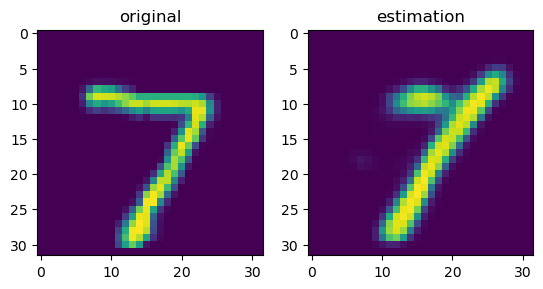

In [240]:
experiment(config, x)

## Apply discriminator weights ?

In [266]:
config['estimator_params']['potential'] = "discriminator_weighted"
config["base_model_params"]["base_model"] = "gan"
config['estimator_params']['lambda'] = 10
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"

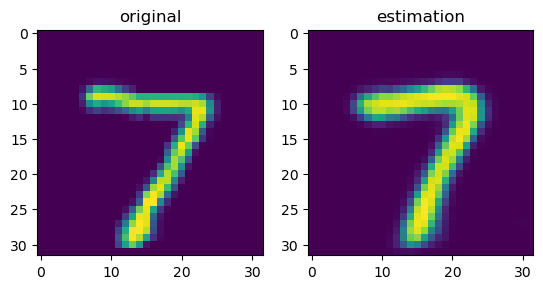

In [280]:
experiment(config, x)

In [281]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["base_model_params"]["base_model"] = "vae"
config['estimator_params']['lambda'] = 1
config['estimator_params']['lambda_score'] = 100

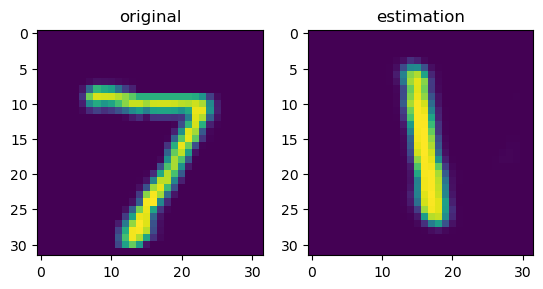

In [310]:
experiment(config, x)

In [14]:
show(config)

operator_params
    operator: CompressedSensing
    size: 13
    num_measurements: 200
estimator_params
    estimator: langevin
    burn_in: 1000
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: random
    potential: discriminator_weighted
    num_steps_map_initaliser: 1
    step_size_map_initaliser: 0.1
    discriminator_base_model: mnist/gan/dcgan
base_model_params
    model_name: mnist/vae/vanilla
    base_model: vae
